# Setup

In [ ]:
# Uncomment before running the notebook in Google Colaboratory
!pip install shap
!pip install eli5

In [ ]:
import warnings
warnings.filterwarnings("ignore")

Required library imports, matplotlib setup

In [ ]:
# Checking runtime environment is Python ≥ 3.5 and `Scikit-Learn` ≥ 0.20
import sys
import sklearn
assert sys.version_info >= (3, 5)
assert sklearn.__version__ >= "0.20"

# Setup Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Other imports
import numpy as np
import pandas as pd
import missingno as msno
import seaborn as sns
import plotly.express as px
import shap
import random

# Constants
rr = 42

**Evaluation Setup**

Display the confusion matrix, accuracy, sensitivity, specificity, F-beta measure, ROC curve and Precision-accuracy curve of given classifiers

In [ ]:
from IPython.display import display
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score

def evaluate(models, X_test, y_true, title=''):
    y_preds = [i.predict(X_test) for i in models]
    res = pd.DataFrame(
        index=[i.__class__.__name__ for i in models],
        columns=['accuracy', 'sensitivity', 'specificity','F1'])
    
    # Plot the confusion matrix
    plt.figure(figsize=(15, 4))
    for x, model in enumerate(models):
        name = model.__class__.__name__
        y_pred = y_preds[x]
        cm = confusion_matrix(y_true, y_pred)
        plt.subplot(1,len(models), x+1)
        plt.imshow(cm, cmap='GnBu')
        plt.colorbar()
        for i, j in [[0,0], [0,1], [1,0], [1,1]]:
            plt.text(i, j, cm[i,j], 
                    color='white', ha='center', va='center',
                    bbox=dict(facecolor='black', alpha=0.25))
        plt.xticks(np.arange(0, 2, step=1)) 
        plt.yticks(np.arange(1, -1, step=-1))   
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(name)
        plt.grid(False)
        
        tn, fp, fn, tp = cm.ravel()
        res['accuracy'][name] = (tp + tn)/(tn + fp + fn + tp)
        res['sensitivity'][name] = tp / (tp + fn)
        res['specificity'][name] = tn / (fp + tn)
        res['F1'][name] = sklearn.metrics.fbeta_score(y_true, y_pred, beta=1) 

    display(res)
    plt.show()
    
    y_scores = [i.predict_proba(X_test)[:,1] for i in models]
    # Plot ROC and Precision Recall Curve
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
    legend = []
    for x, model in enumerate(models):
        y_pred, y_score = y_preds[x], y_scores[x]
        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)
        ax1.plot(fpr, tpr, lw=2, label=f'{model.__class__.__name__} (AUC = %0.2f)'%roc_auc)
        precision, recall, _ = precision_recall_curve(y_true, y_score)
        avg_prec = average_precision_score(y_true, y_score)
        legend.append(f'{model.__class__.__name__} (AP = %0.2f)' % avg_prec)
        ax2.step(recall, precision, where='post')
    
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax1.set(xlabel='False Positive Rate', ylabel='True Positive Rate', title='ROC Curve')
    ax1.legend(loc="lower right")
    ax1.grid(b=True)
    ax2.set(xlabel='Recall', ylabel='Precision', title='Precision Recall Curve')
    ax2.legend(legend)
    ax2.grid(b=True)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.01])
    plt.subplots_adjust(0.125, 0.1, 0.9, 0.9, 0.3, 0.5)
    plt.show()

# Loading and inspecting the dataset

In [ ]:
import requests
import tarfile
url = "https://raw.githubusercontent.com/beoutbreakprepared/nCoV2019/master/latest_data/latestdata.tar.gz"
target = "latestdata.tar.gz"

In [ ]:
# Download the latest dataset from GitHub and save it locally
response = requests.get(url, stream=True)
if response.status_code == 200:
    print("Downloading the dataset...")
    with open(target, "wb") as dataset:
        dataset.write(response.raw.read())
        print("Finished downloading the dataset.")
else:
    print("Could not fetch dataset")

Finished downloading the dataset.


In [ ]:
# Load the dataset into a DataFrame
dataset_tar = tarfile.open(target, 'r')
try:
    f = dataset_tar.extractfile('latestdata.csv')
    # The dataset has mixed datatypes in several columns therefore low_memory flag has to be set to False
    covid_data = pd.read_csv(f, index_col='ID', low_memory=False)
except Exception as e:
    print("Error:", e)
else:
    print("Successfully read the dataset")

Successfully read the dataset


In [ ]:
covid_data

,age,sex,city,province,country,latitude,longitude,geo_resolution,date_onset_symptoms,date_admission_hospital,date_confirmation,symptoms,lives_in_Wuhan,travel_history_dates,travel_history_location,reported_market_exposure,additional_information,chronic_disease_binary,chronic_disease,source,sequence_available,outcome,date_death_or_discharge,notes_for_discussion,location,admin3,admin2,admin1,country_new,admin_id,data_moderator_initials,travel_history_binary
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000-1-1,NaN,male,Shek Lei,Hong Kong,China,22.365019,114.133808,point,NaN,NaN,14.02.2020,NaN,NaN,22.01.2020,China,NaN,Case 55; mainland China travel via the Lok Ma ...,False,NaN,https://www.scmp.com/news/hong-kong/health-env...,NaN,"critical condition, intubated as of 14.02.2020",NaN,NaN,Shek Lei,NaN,NaN,Hong Kong,China,8029.0,NaN,NaN
000-1-10,78,male,Vo Euganeo,Veneto,Italy,45.297748,11.658382,point,NaN,NaN,21.02.2020,NaN,NaN,NaN,NaN,NaN,Hospitalized on 12.02.2020 for other reasons,False,NaN,https://www.corriere.it/cronache/20_febbraio_2...,NaN,death,22.02.2020,NaN,Vo' Euganeo,NaN,NaN,Veneto,Italy,8954.0,NaN,NaN
000-1-100,61,female,NaN,NaN,Singapore,1.353460,103.815100,admin0,NaN,NaN,14.02.2020,NaN,NaN,NaN,NaN,NaN,"Case 65; family member of Case 50, a DBS emplo...",False,NaN,https://www.channelnewsasia.com/news/singapore...,NaN,discharge,17.02.2020,NaN,NaN,NaN,NaN,NaN,Singapore,200.0,NaN,NaN
000-1-1000,NaN,NaN,Zhengzhou City,Henan,China,34.629310,113.468000,admin2,NaN,NaN,26.01.2020,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,https://news.163.com/special/epidemic/?spssid=...,NaN,NaN,NaN,NaN,NaN,NaN,Zhengzhou City,Henan,China,10091.0,NaN,NaN
000-1-10000,NaN,NaN,Pingxiang City,Jiangxi,China,27.513560,113.902900,admin2,NaN,NaN,14.02.2020,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,http://hc.jiangxi.gov.cn/doc/2020/02/15/138898...,NaN,NaN,NaN,NaN,NaN,NaN,Pingxiang City,Jiangxi,China,7060.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
010-99995,52,female,Calleria,Coronel Portillo,Peru,-8.378190,-74.539700,point,NaN,NaN,17.05.2020,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Peru,14429.0,NaN,False
010-99996,52,female,Pueblo Libre,Lima,Peru,-12.076530,-77.067350,point,NaN,NaN,17.05.2020,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Peru,14695.0,NaN,False
010-99997,52,female,Comas,Lima,Peru,-11.932980,-77.040850,point,NaN,NaN,17.05.2020,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Peru,14400.0,NaN,False


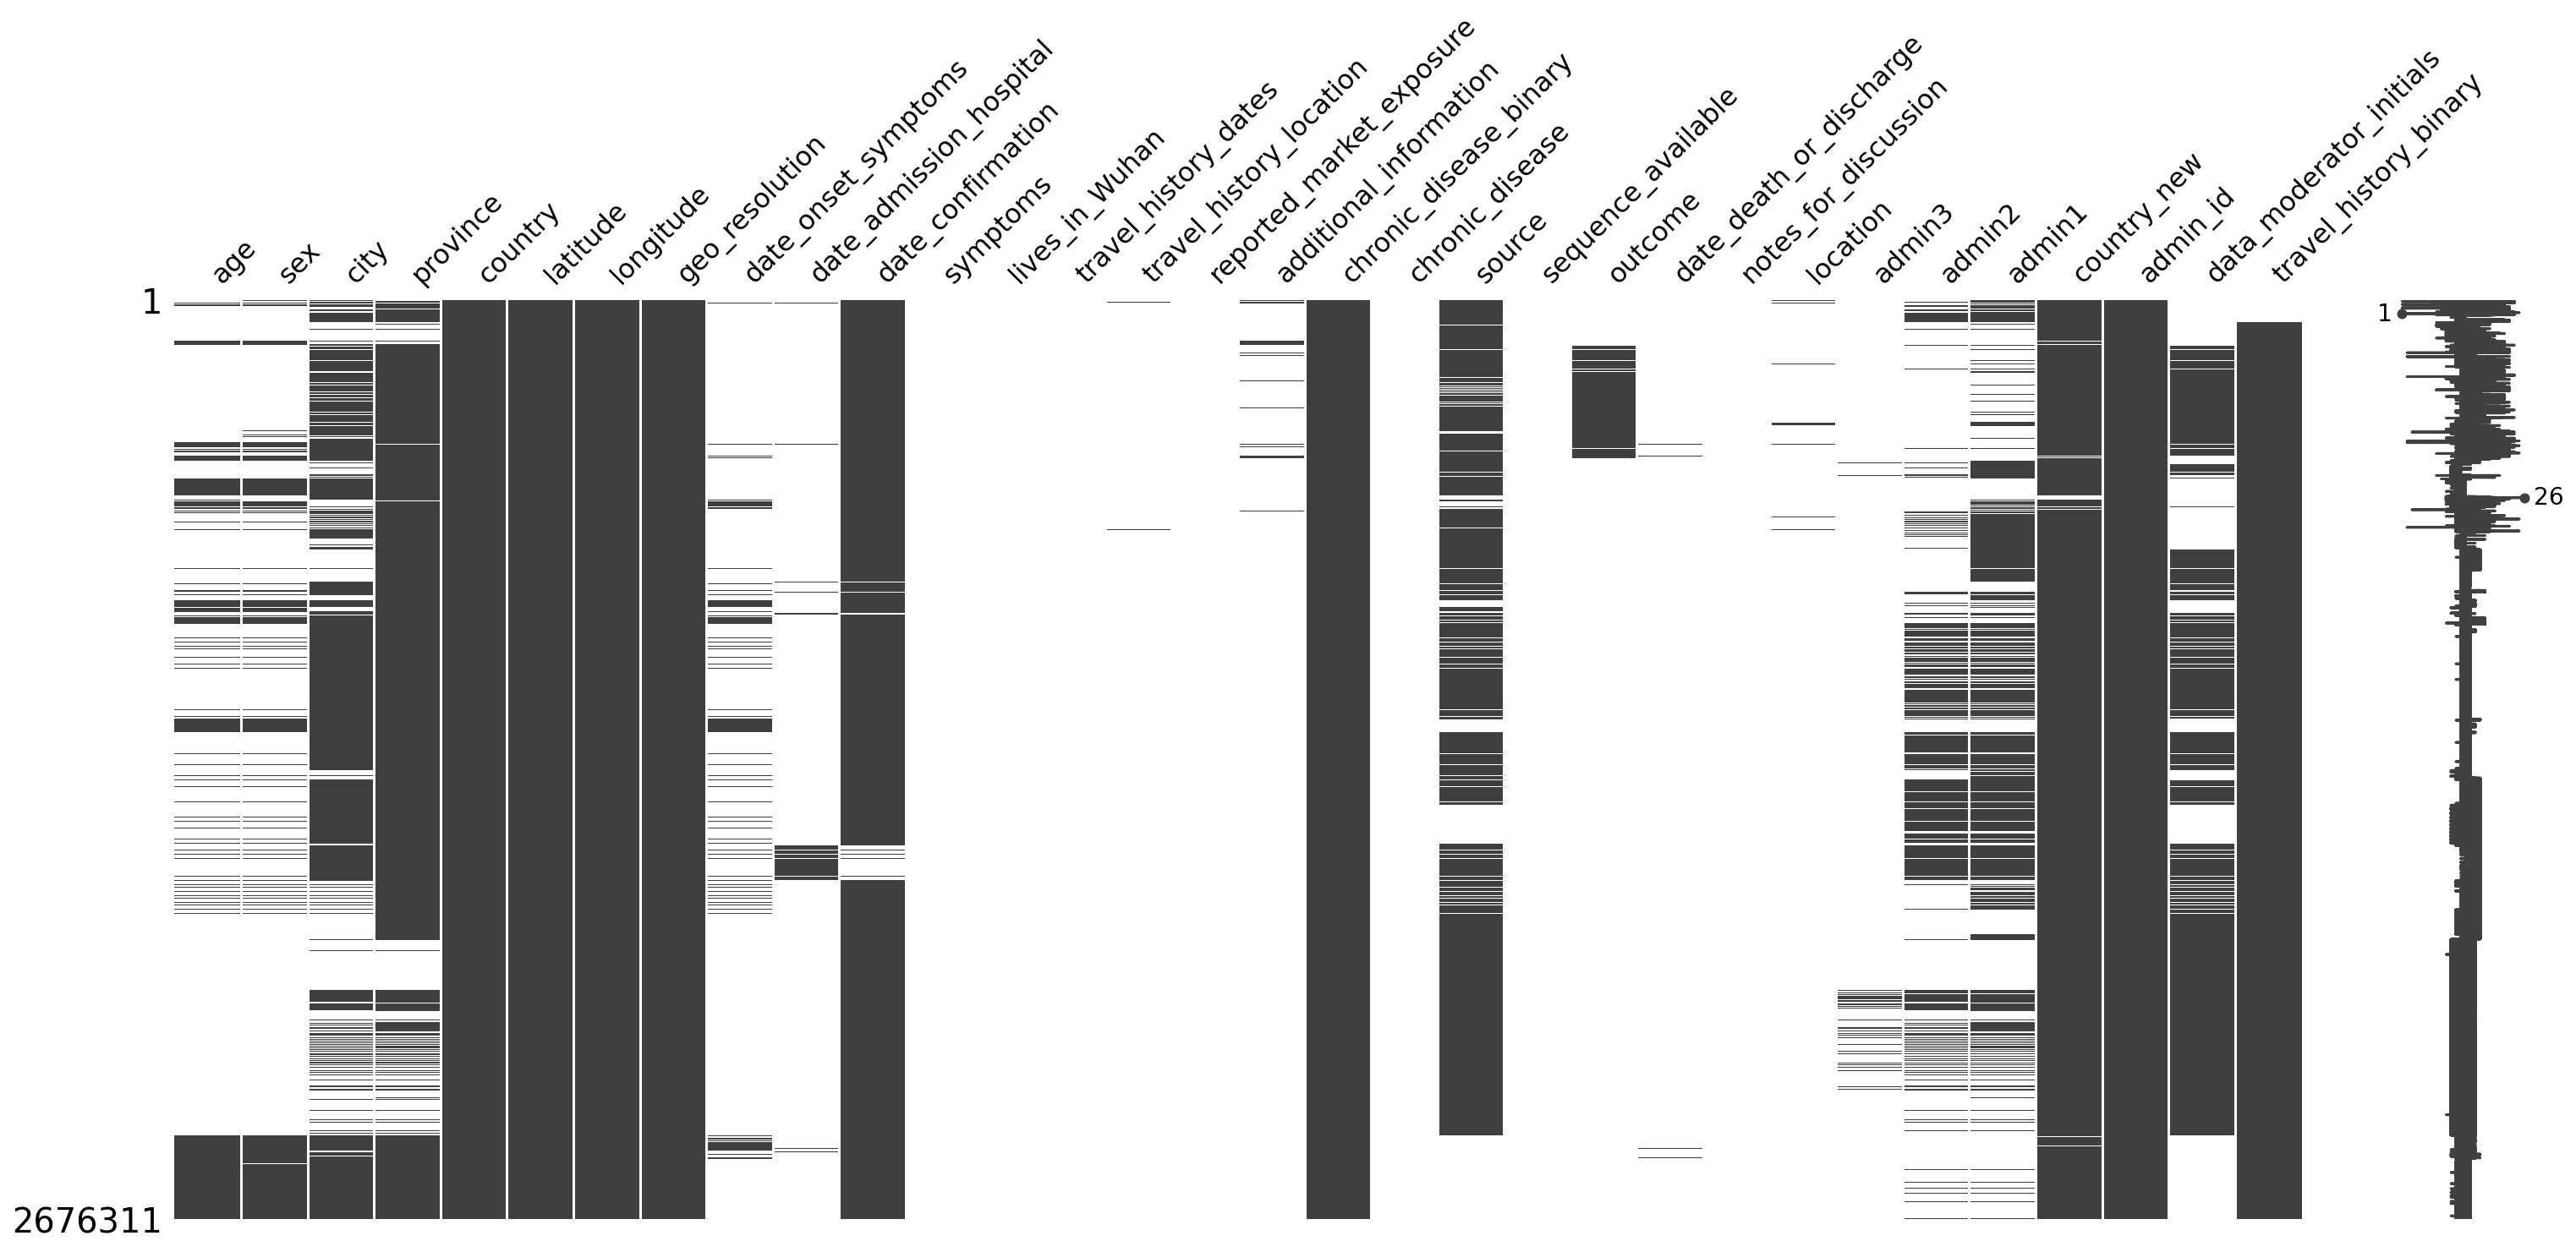

In [ ]:
# Visualise the missing values in the dataset side by side
msno.matrix(covid_data)

In [ ]:
# Visualise the geographic distribution of the recorded cases in the datset
num_cases = covid_data.groupby('country').size().reset_index(name='No. Cases')
fig = px.choropleth(num_cases, locations="country", locationmode='country names',
                    color="No. Cases", hover_name="country", color_continuous_scale='reds',
                    title='Total number of COVID-19 cases in the dataset by country')

fig.show()

# Cleaning

In [ ]:
# Delete columns with no information, repeated information or information not related to Covid-19 cases 
covid_data.drop(columns=['symptoms', 'lives_in_Wuhan', 'travel_history_dates', 'travel_history_location',
                         'reported_market_exposure', 'additional_information','chronic_disease', 'source', 
                         'sequence_available','notes_for_discussion', 'location', 'admin3', 'admin2', 
                         'admin1','country_new', 'admin_id', 'data_moderator_initials','travel_history_binary', 
                         'geo_resolution'], inplace=True)

# Dropping index as case ids are not required
covid_data.reset_index(inplace=True, drop=True)

In [ ]:
# Encode the sex attribute
covid_data.sex = covid_data.sex.map({'male':1, 'female':0})
# Convert chronic_disease_binary to int (required for SHAP analysis)
covid_data.chronic_disease_binary = covid_data.chronic_disease_binary.astype(int) 

## Cleaning `age`

> Note - range entries e.g `'25-30'`, with a difference greater the 24 are discarded

In [ ]:
def parse_age(x):
    if x != x:
        return x
    try:
        return round(float(x))
    except:
        if x[-1] == '-' or x[-1] == '+':
            return int(x[:-1])
        elif '-' in x:
            a, b = x.split('-')
            try:
                a, b = int(a), int(b)
                return np.nan if b - a > 24 else round((b-a)/2)  
            except:
                return int(a)
        elif 'month' in x:
            return round(int(x.split(' ')[0])/12)
        elif 'weeks' in x:
            return 0

covid_data['age'] = covid_data.age.map(parse_age)

## Identifying severe cases

A severe Covid-19 case is defined as the one that requires the patient to be hospitalization or if it leads to death. We can check if the patient was admitted to the hospital by checking for a non-null entry in `date_admission_hospital` column.

In [ ]:
covid_data['hosp'] = covid_data.date_admission_hospital.map(lambda x : 1 if x == x else 0)

Similarly a non-null entry in `date_death_or_discharge` column indicates if the patient was hospitalized and/or deceased

In [ ]:
hosp_or_dead = covid_data['date_death_or_discharge'].map(lambda x: 'hosp_or_dead' if x==x else np.nan)
covid_data.outcome.fillna(hosp_or_dead, inplace=True)

Finally, we can categorise the outcome and, combine all of the above information into a single column

In [ ]:
covid_data.outcome = covid_data.outcome.str.lower()
covid_data.outcome.unique()

array(['critical condition, intubated as of 14.02.2020', 'death',
       'discharge', nan, 'discharged', 'discharged from hospital',
       'not hospitalized', 'recovered', 'recovering at home 03.03.2020',
       'released from quarantine', 'severe', 'stable', 'hosp_or_dead',
       'died', 'dead',
       'symptoms only improved with cough. currently hospitalized for follow-up.',
       'treated in an intensive care unit (14.02.2020)', 'alive',
       'deceased', 'stable condition', 'under treatment',
       'critical condition', 'receiving treatment', 'severe illness',
       'unstable', 'hospitalized', 'migrated', 'migrated_other',
       'https://www.mspbs.gov.py/covid-19.php'], dtype=object)

In [ ]:
is_severe = ['hosp_or_dead', 'death', 'died', 'dead', 'severe', 'critical', 'intensive',
              'hospitalized', 'treatment', 'treated', 'discharge', 'discharged']

def classify_outcome(x):
    if x == x and x != 'not hospitalized':
        return int(any([i in is_severe for i in x.split(' ')]))     
    elif x == x:
        return 0
    else:
        return x
    
covid_data['is_severe'] = covid_data.outcome.map(classify_outcome)
covid_data['is_severe'].fillna(covid_data.hosp, inplace = True)

## Inspecting the cleaned dataset

In [ ]:
# country is only included for visualisation purposes it will not be used in training
cleaned = covid_data[['age', 'sex', 'latitude', 'longitude', 'country', 'chronic_disease_binary', 'is_severe']].dropna()
cleaned.reset_index(drop=True, inplace=True)
cleaned

,age,sex,latitude,longitude,country,chronic_disease_binary,is_severe
0,78.0,1.0,45.297748,11.658382,Italy,0,1.0
1,61.0,0.0,1.353460,103.815100,Singapore,0,1.0
2,66.0,1.0,45.948140,123.439600,China,0,0.0
3,27.0,0.0,42.858020,125.152100,China,0,0.0
4,17.0,1.0,43.783530,124.672900,China,0,0.0
...,...,...,...,...,...,...,...
573692,52.0,0.0,-8.378190,-74.539700,Peru,0,0.0
573693,52.0,0.0,-12.076530,-77.067350,Peru,0,0.0
573694,52.0,0.0,-11.932980,-77.040850,Peru,0,0.0
573695,52.0,1.0,-12.000740,-77.118240,Peru,0,0.0


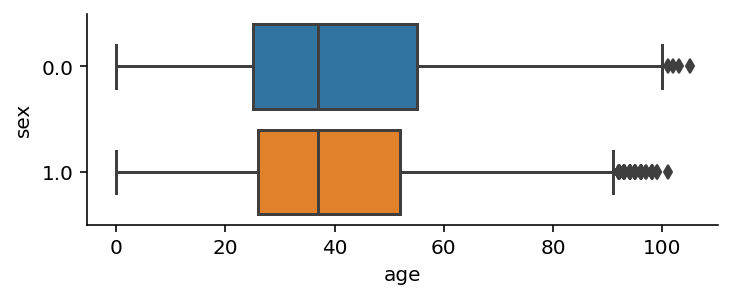

In [ ]:
sns.catplot(y="sex", x="age", data=cleaned.groupby(['is_severe']).get_group(1), 
            kind="box", height=2, aspect=2.5, orient='h')

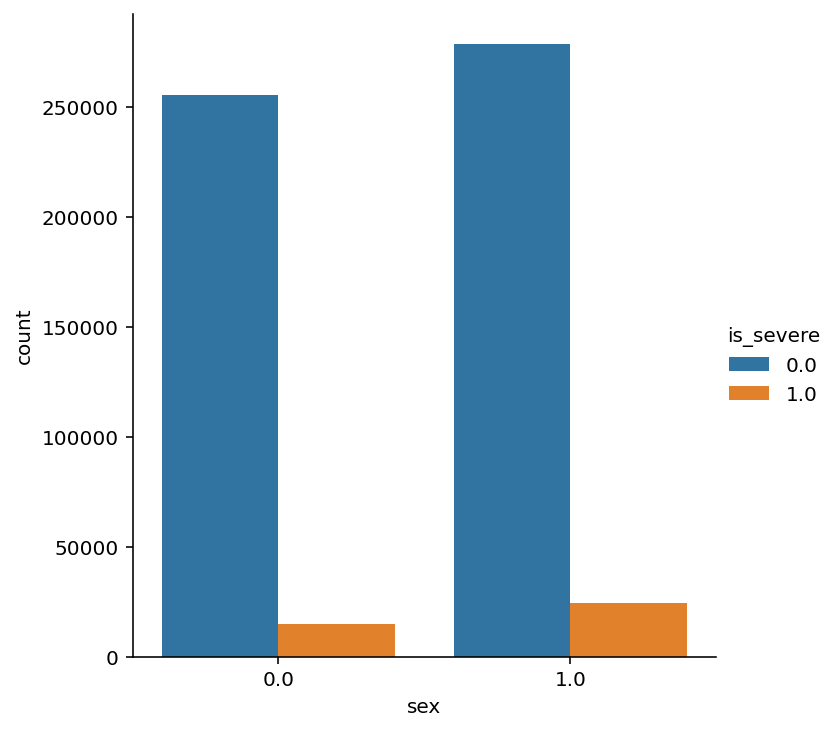

In [ ]:
sns.catplot(data=cleaned, x='sex', kind='count', hue='is_severe')

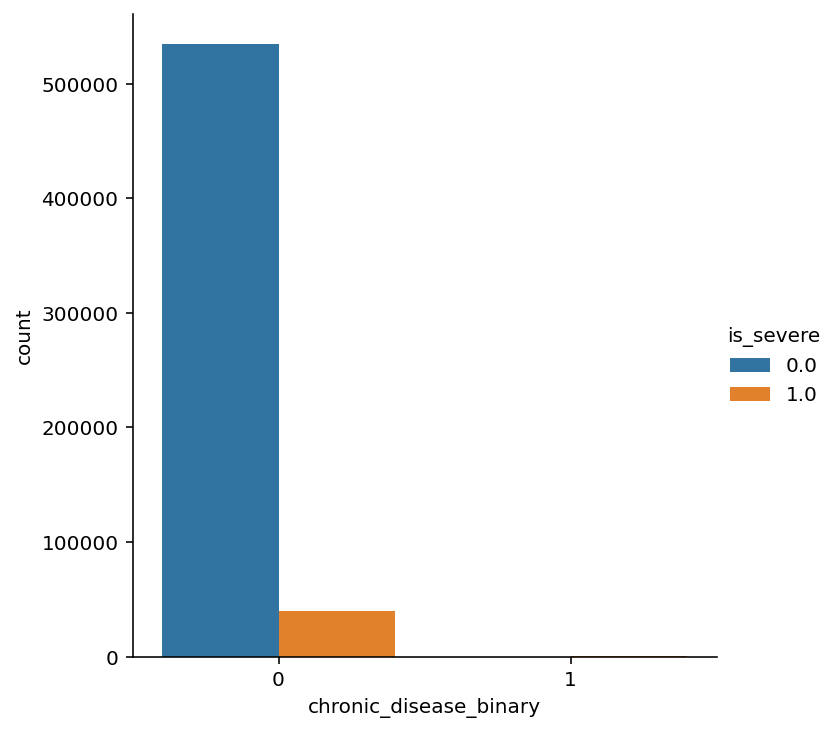

In [ ]:
sns.catplot(data=cleaned, x='chronic_disease_binary', kind='count', hue='is_severe')

In [ ]:
num_cases = cleaned.groupby('country').size().reset_index(name='No. Cases')
fig = px.choropleth(num_cases, locations="country", locationmode='country names',
                    color="No. Cases", hover_name="country", color_continuous_scale='reds',
                    title='Total number of COVID-19 cases in the cleaned dataset by country')

fig.show()

## Correlation matrix for feature selection

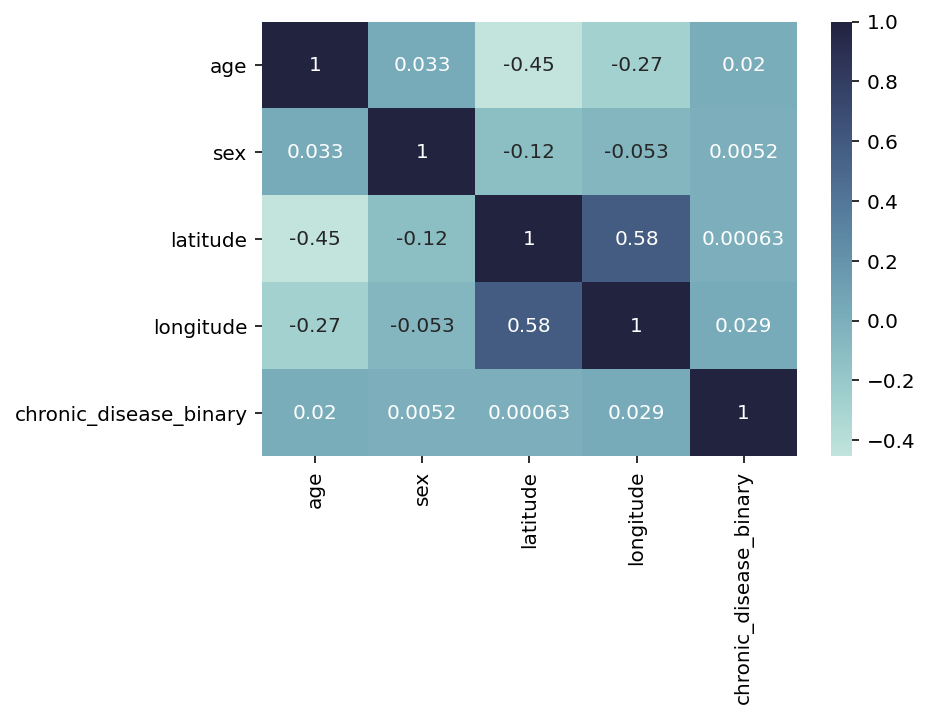

In [ ]:
corr = cleaned.drop(['is_severe'], axis=1).corr()
sns.heatmap(corr, annot=True, 
            xticklabels=corr.columns.values, 
            yticklabels=corr.columns.values,
            cmap=sns.color_palette("ch:start=.1,rot=-.3", as_cmap=True))

# Train, test and evaluate baseline models


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [ ]:
cleaned['age'] = (cleaned.age - cleaned.age.mean())/cleaned.age.std()
X, y = cleaned.drop(['is_severe', 'country'], axis=1), cleaned['is_severe']

# Get ratio of +ve to -Ve cases
a, b = sorted(y.value_counts().to_list())
print(y.value_counts())
print(f'ratio: {round(b//a)}:{1}')

0.0    534170
1.0     39527
Name: is_severe, dtype: int64
ratio: 13:1


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    stratify=y, random_state=rr, shuffle=True)

base_clfs = [
    ('RandomForest', RandomForestClassifier(random_state=rr)),
    ('KNeighbors', KNeighborsClassifier()),
    ('LogisticRegression', LogisticRegression(random_state=rr))
]

for clf_name, clf in base_clfs:
    print("Training", clf_name)
    clf.fit(X_train, y_train)

Training RandomForest
Training KNeighbors
Training LogisticRegression


,accuracy,sensitivity,specificity,F1
RandomForestClassifier,0.981105,0.810676,0.993716,0.855325
KNeighborsClassifier,0.980193,0.812616,0.992593,0.849698
LogisticRegression,0.893719,0.0345758,0.957292,0.042905


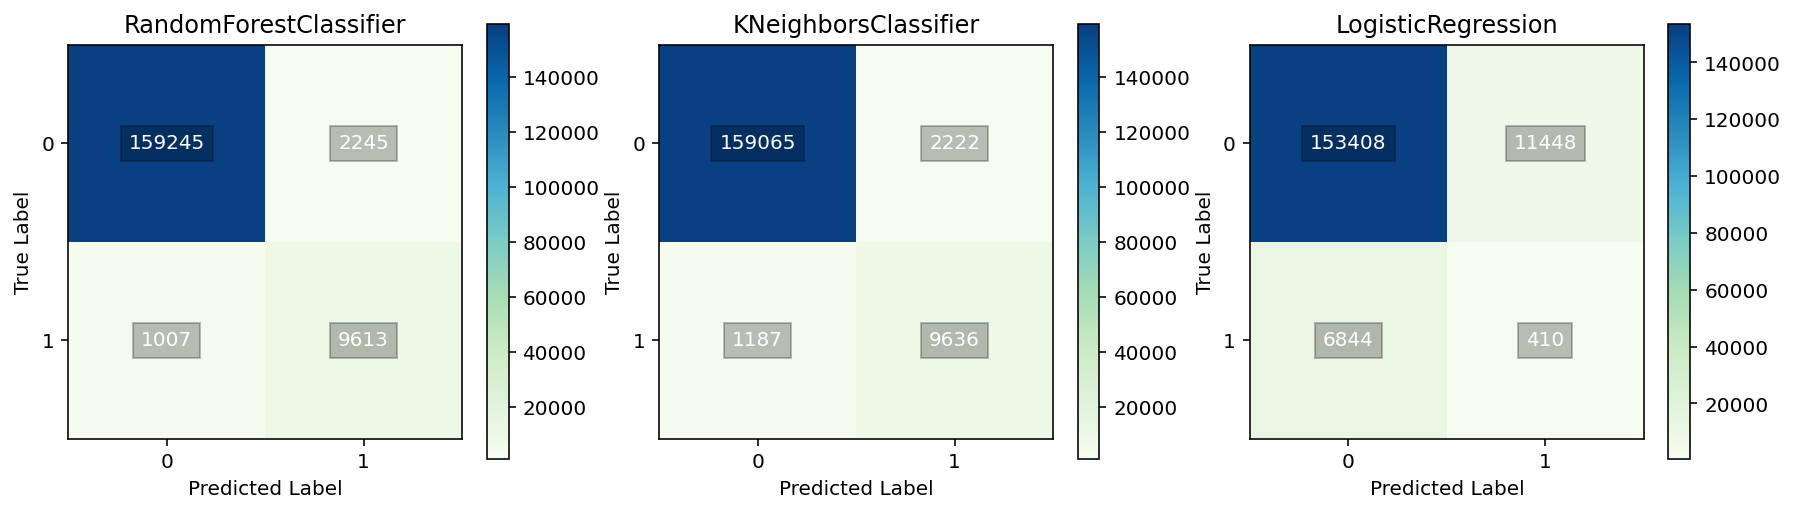

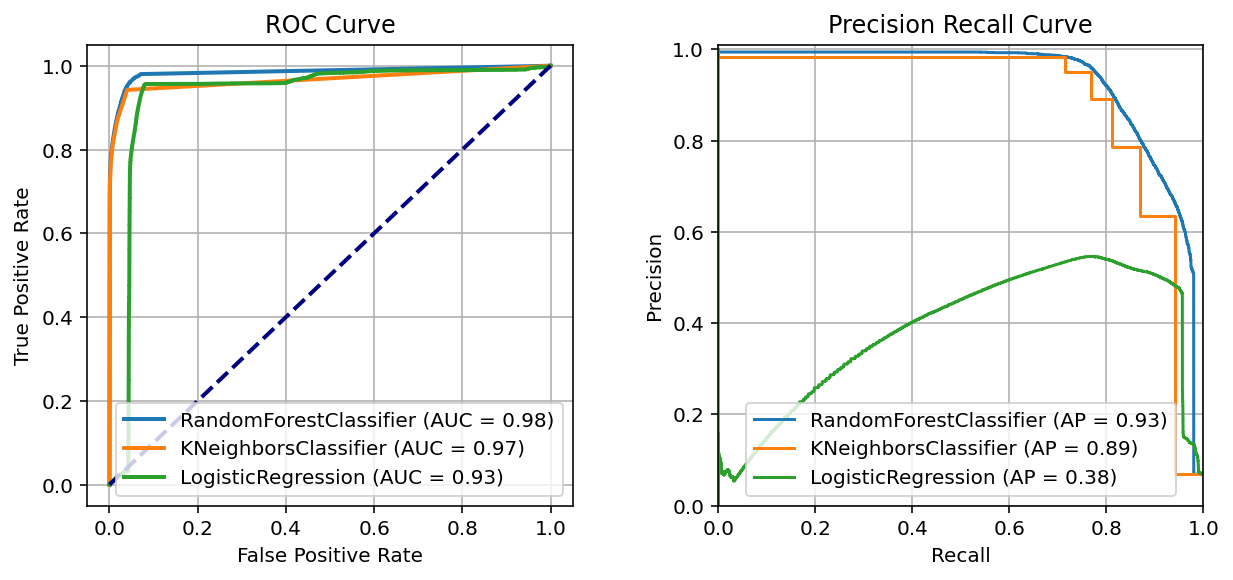

In [ ]:
evaluate([j for i,j in base_clfs], X_test, y_test)

# balancing the dataset

In [ ]:
# Randomly undersample the majority target class
sample_size = min(cleaned['is_severe'].value_counts())
under_sample = lambda x: x.sample(n=sample_size, random_state=rr)
under_sampled = cleaned.groupby(['is_severe']).apply(under_sample).reset_index(drop=True)

X_rus, y_rus = under_sampled.drop(['is_severe', 'country'], axis=1), under_sampled['is_severe']

a, b = sorted(y_rus.value_counts().to_list())
print(y_rus.value_counts())
print(f'ratio: {round(b//a)}:{1}')

1.0    39527
0.0    39527
Name: is_severe, dtype: int64
ratio: 1:1


# Tuning hyperparameters of baseline models

In [ ]:
params = {
    'RandomForest':{
       'max_features': ['sqrt', 'log2'],
       'n_estimators': [50, 100, 300]
    },
    'KNeighbors':{
        'n_neighbors': [7, 11, 19],  
    },
    'LogisticRegression':{
        'solver': ['newton-cg', 'lbfgs', 'sag'],
        'C': [0.5, 1, 1.5],
        'max_iter':[1000]
    }
}

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, test_size=0.3, 
                                                    stratify=y_rus, random_state=rr, shuffle=True)
tuned_clfs = []
skf = StratifiedKFold(n_splits=3)

for clf_name, clf in base_clfs:
    grid_search = GridSearchCV(estimator=clf, param_grid=params[clf_name], cv=skf, n_jobs= -1, verbose=True)
    grid_search.fit(X_train, y_train)
    print(clf_name, grid_search.best_score_, grid_search.best_params_)
    tuned_clfs.append(grid_search.best_estimator_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   50.8s finished


RandomForest 0.9592316338104495 {'max_features': 'sqrt', 'n_estimators': 100}
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    6.1s finished


KNeighbors 0.9633879666103988 {'n_neighbors': 11}
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   52.6s finished


LogisticRegression 0.9397148048238332 {'C': 1.5, 'max_iter': 1000, 'solver': 'newton-cg'}


,accuracy,sensitivity,specificity,F1
RandomForestClassifier,0.960619,0.972255,0.948984,0.96107
KNeighborsClassifier,0.963275,0.977568,0.948984,0.963791
LogisticRegression,0.938609,0.958762,0.918459,0.93982


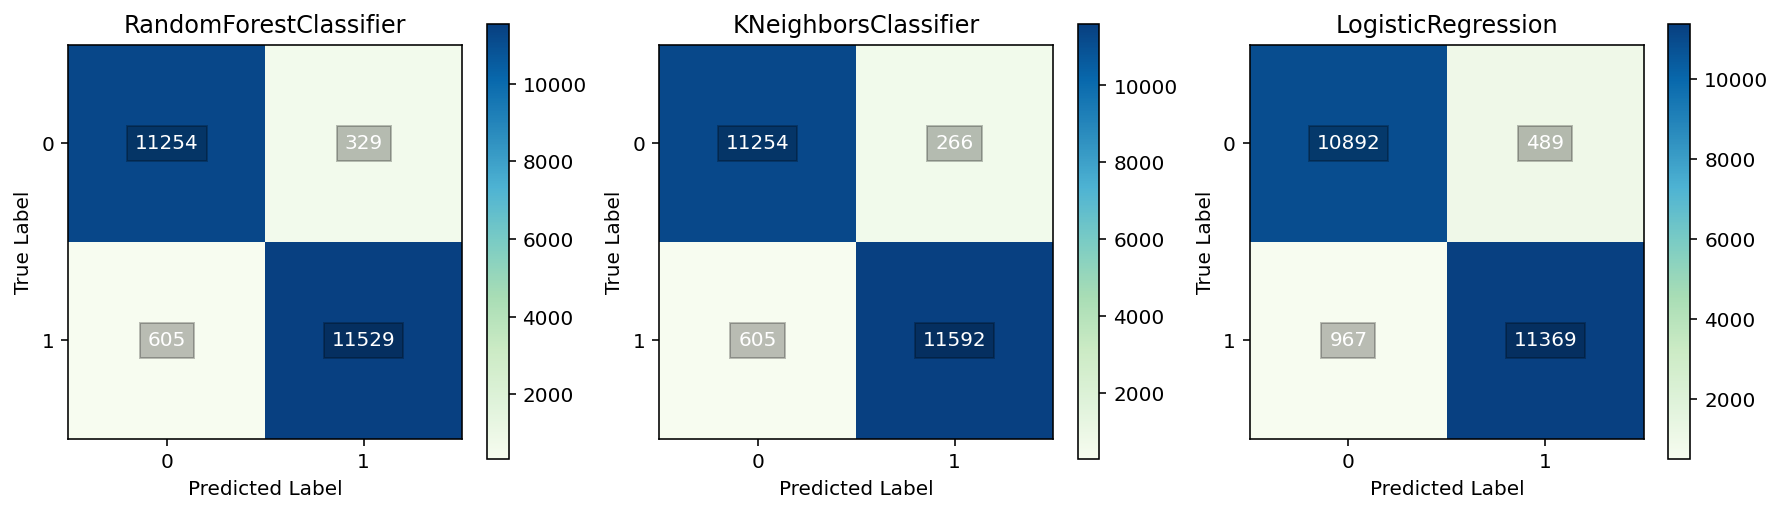

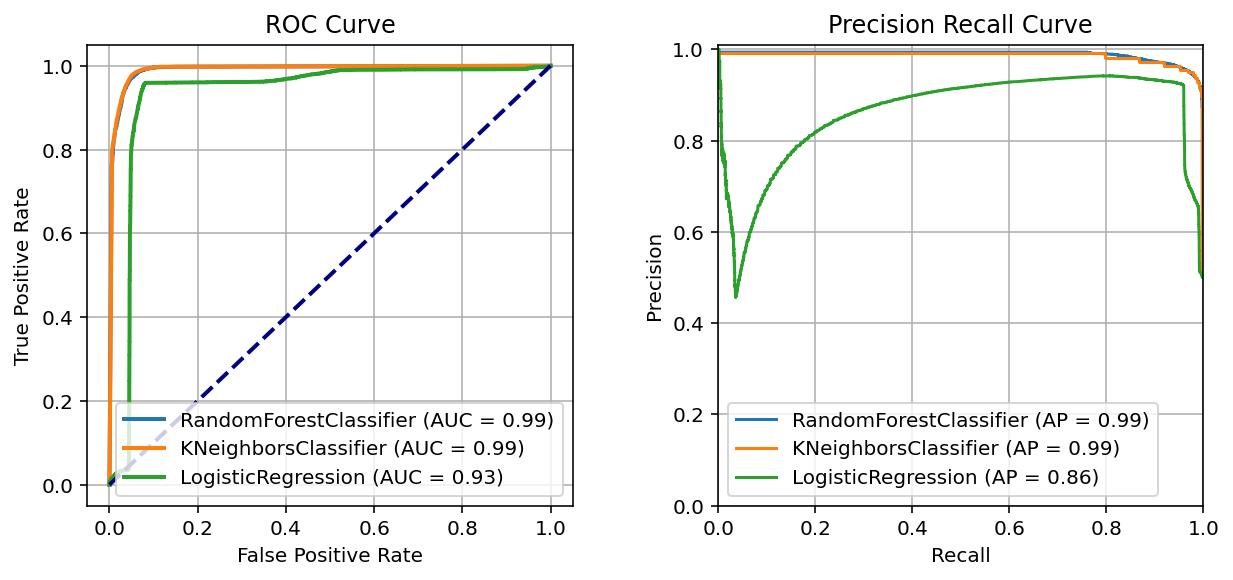

In [ ]:
evaluate(tuned_clfs, X_test, y_test)

## Feature importance

In [ ]:
from eli5 import show_weights
from eli5.sklearn import PermutationImportance

for clf in tuned_clfs:
    print('\n', clf.__class__.__name__)
    perm = PermutationImportance(clf, random_state=1).fit(X_test, y_test)
    display(show_weights(perm, feature_names=X_test.columns.to_list()))


 RandomForestClassifier


Weight,Feature
0.3157 ± 0.0034,longitude
0.2488 ± 0.0036,latitude
0.0159 ± 0.0020,age
0.0010 ± 0.0003,chronic_disease_binary
0.0010 ± 0.0008,sex



 KNeighborsClassifier


Weight,Feature
0.4459 ± 0.0069,longitude
0.2743 ± 0.0016,latitude
0.0167 ± 0.0018,age
0.0005 ± 0.0008,sex
0.0002 ± 0.0000,chronic_disease_binary



 LogisticRegression


Weight,Feature
0.3421 ± 0.0059,longitude
0.2365 ± 0.0056,latitude
0.0009 ± 0.0003,chronic_disease_binary
0.0008 ± 0.0006,age
0.0000 ± 0.0001,sex


## SHAP summary plots

Analysing how feature values affect the model prediction

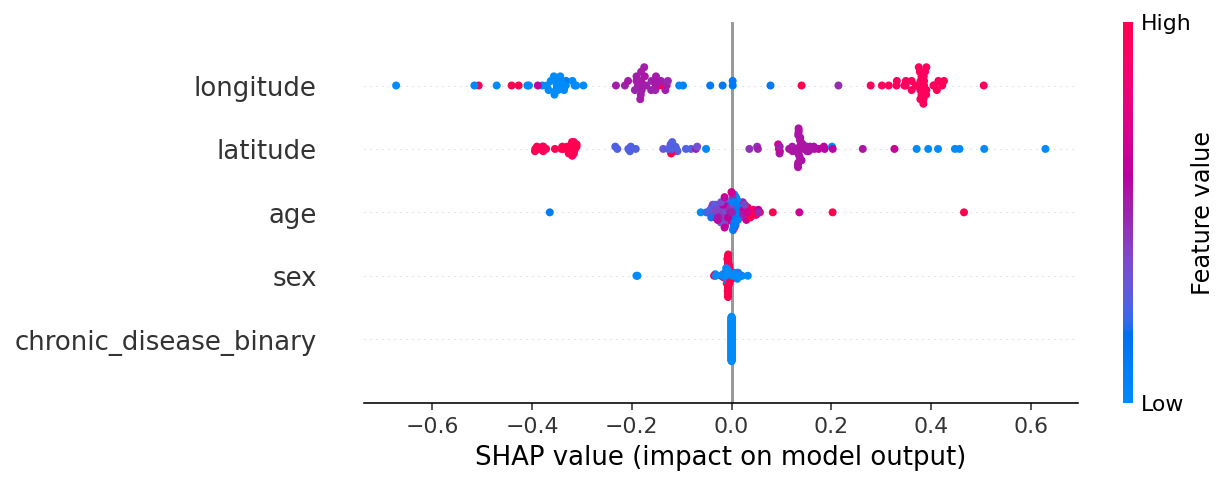

In [ ]:
# Random Forest Classifier
X_train_summary = shap.kmeans(X_test, 100)
samples = X_test.sample(n=100)
explainer_rf = shap.KernelExplainer(tuned_clfs[0].predict, X_train_summary)
shap_values_rf = explainer_rf.shap_values(samples)
shap.summary_plot(shap_values_rf, samples)

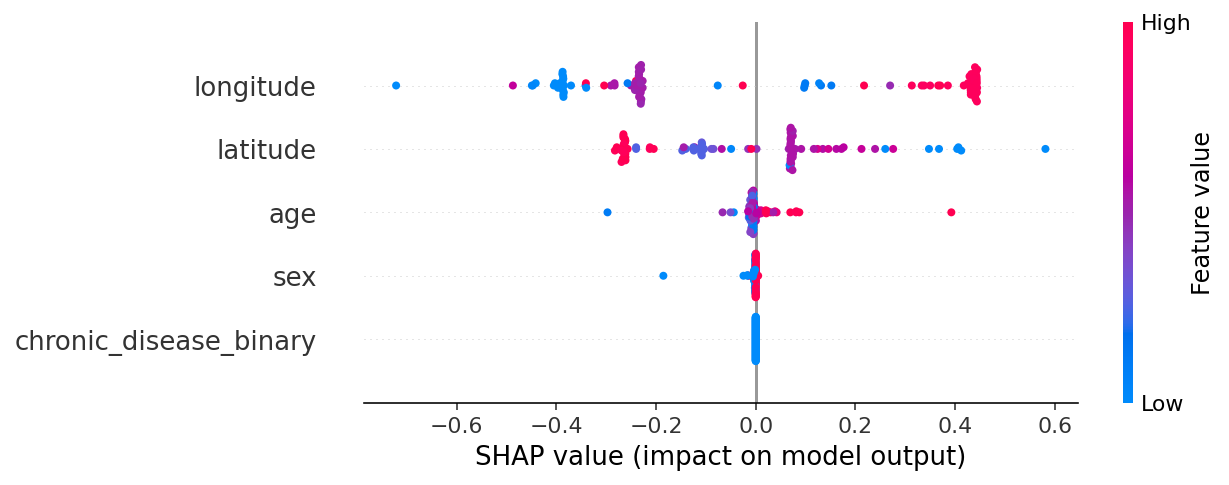

In [ ]:
# K-Neighbors Classifier
explainer_knn = shap.KernelExplainer(tuned_clfs[1].predict, X_train_summary)
shap_values_knn = explainer_knn.shap_values(samples)
shap.summary_plot(shap_values_knn, samples)

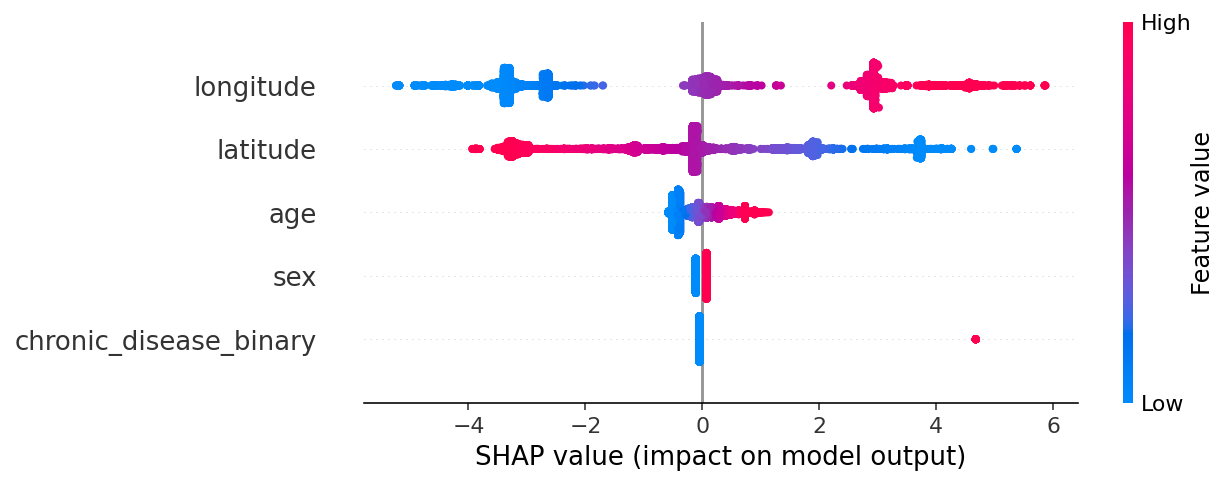

In [ ]:
# Logistic Regression
explainer_lr = shap.LinearExplainer(tuned_clfs[2], X_train)
shap_values_lr = explainer_lr.shap_values(X_test)
shap.summary_plot(shap_values_lr, X_test)